Goal: To predict whether passengers were correctly transported to another dimension

# Import libraries and Data

In [68]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
train = pd.read_csv('data/train.csv', na_values = "NA")
train.columns = train.columns.str.lower()
train.head()

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
#I replaced all False values with 0 and True values with 1
train = train.replace({True: 1, False: 0})

**Per Kaggle:**
-  PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
-  HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
-  CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
-  Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
-  Destination - The planet the passenger will be debarking to.
-  Age - The age of the passenger.
-  VIP - Whether the passenger has paid for special VIP service during the voyage.
-  RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
-  Name - The first and last names of the passenger.
-  Transported - Whether the passenger was transported to another dimension.

# Exploratory Data Analysis - EDA

In [4]:
train.describe()

,cryosleep,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported
count,8476.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,0.358306,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,0.479531,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passengerid   8693 non-null   object 
 1   homeplanet    8492 non-null   object 
 2   cryosleep     8476 non-null   float64
 3   cabin         8494 non-null   object 
 4   destination   8511 non-null   object 
 5   age           8514 non-null   float64
 6   vip           8490 non-null   float64
 7   roomservice   8512 non-null   float64
 8   foodcourt     8510 non-null   float64
 9   shoppingmall  8485 non-null   float64
 10  spa           8510 non-null   float64
 11  vrdeck        8505 non-null   float64
 12  name          8493 non-null   object 
 13  transported   8693 non-null   int64  
dtypes: float64(8), int64(1), object(5)
memory usage: 950.9+ KB


In [6]:
#looking for unique values
unique = train.nunique()
unique

passengerid     8693
homeplanet         3
cryosleep          2
cabin           6560
destination        3
age               80
vip                2
roomservice     1273
foodcourt       1507
shoppingmall    1115
spa             1327
vrdeck          1306
name            8473
transported        2
dtype: int64

In [7]:
#Check for duplicated passenger info.  There isn't any to deal with.
duplications = train.duplicated().sum()
duplications

0

Text(0.5, 0, 'Transported by Homeplanet')

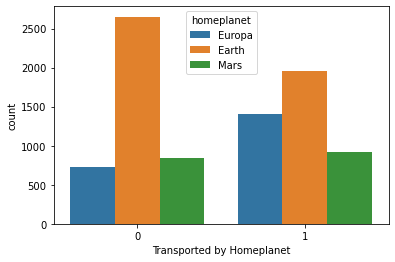

In [8]:
sns.countplot(data=train, x ='transported', hue = 'homeplanet')
plt.xlabel('Transported by Homeplanet' )

Text(0.5, 0, 'Transported Cryosleep Passengers')

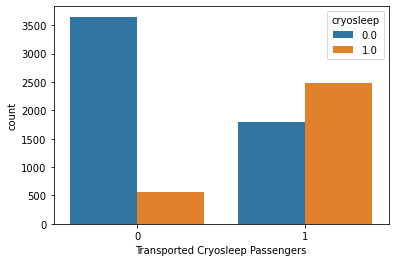

In [9]:
sns.countplot(data=train, x ='transported', hue = 'cryosleep')
plt.xlabel('Transported Cryosleep Passengers' )

Text(0.5, 0, 'VIP Passengers Transported')

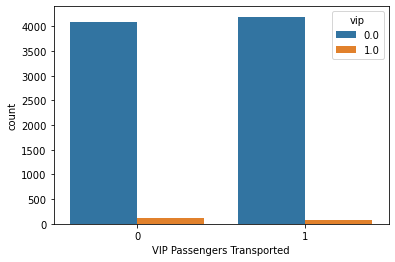

In [10]:
sns.countplot(data=train, x ='transported', hue = 'vip')
plt.xlabel('VIP Passengers Transported' )

Text(0.5, 0, 'Transported by Destination')

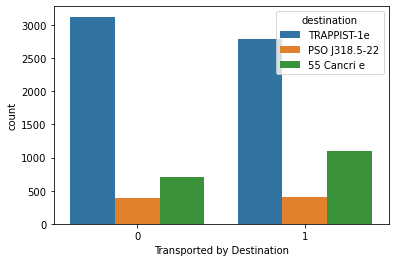

In [11]:
sns.countplot(data=train, x ='transported', hue = 'destination')
plt.xlabel('Transported by Destination' )

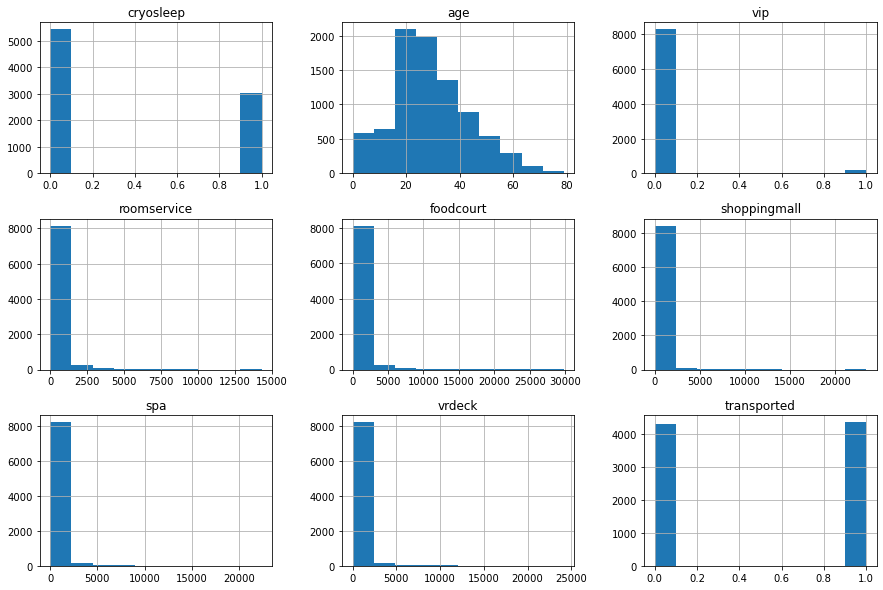

In [12]:
train.hist(figsize=(15,10))
plt.show()

From the above quick analysis, it appears that being VIP did not affect the success rate of the transportation.  There was a positive affect of cryosleep and being from Europa on being successfully transported.  I will calculate a correlation matrix after the missing data is filled in to see if there are other correlations.

# Correlation

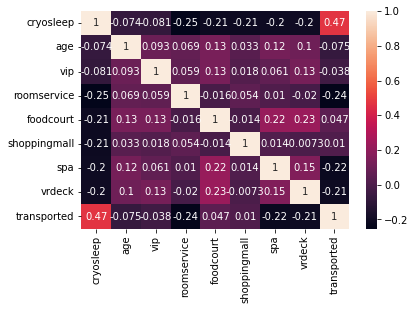

In [13]:
#This is a heatmap of the above information that makes it easier to see the features
#that correlate with each other (if any).
sns.heatmap(train.corr(), annot=True)
plt.show()

It appears that the feature with the highest correlation to being successfully transported is cryosleep

In [14]:
#Homeplanet was not included in the above correlation as it is a string.  
#We can use .get_dummies().  This converts a categorical variable into 
#dummy variables

train['homeplanet'].str.get_dummies().corrwith(train['transported']/train['transported'].max())

Earth    -0.169019
Europa    0.176916
Mars      0.019544
dtype: float64

This shows that being from Earth has a strong negative correlation to being transported successfully whereas the other 2 locations have a slightly positive correlation.

In [15]:
#Groups were not included in the above correlation as it is a string. I have seperated it 
#We can use .get_dummies().  This converts a categorical variable into 
#dummy variables

train['destination'].str.get_dummies().corrwith(train['transported']/train['transported'].max())

55 Cancri e      0.108722
PSO J318.5-22    0.000092
TRAPPIST-1e     -0.094700
dtype: float64

This shows that the destination of TRAPPIST has a negative correlation to being successfully transported as compared to the other two destinations.

### Does Group size affect transportation?

In [16]:
#split the passengerid so we can establish groups (who is travelling with who).  
#This dataset does not distinguish between families or friend groups
train[['passengerid_1','passengerid_2']] = train['passengerid'].str.split('_', 2, expand=True)

In [17]:
#Groups was not included in the above correlation as it is a string.  
#We can use .get_dummies().  This converts a categorical variable into 
#dummy variables

train['passengerid_2'].str.get_dummies().corrwith(train['transported']/train['transported'].max())

01   -0.087695
02    0.048582
03    0.060768
04    0.029559
05    0.010575
06    0.008031
07   -0.000529
08   -0.003257
dtype: float64

<AxesSubplot:xlabel='passengerid_2', ylabel='transported'>

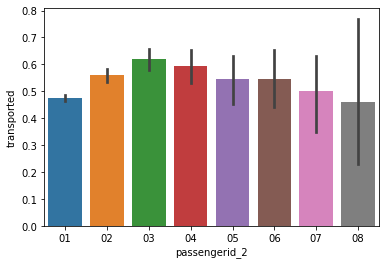

In [18]:
#Let's see if family size affects survival rates

sns.barplot(x = 'passengerid_2', y = 'transported', data = train)

<AxesSubplot:title={'center':'Successful Transportation by Group Size'}, xlabel='passengerid_2'>

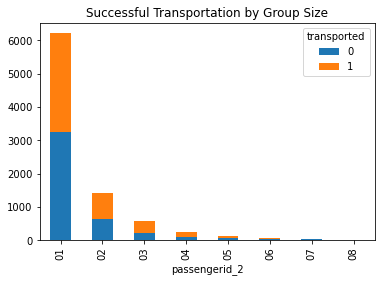

In [19]:
pd.crosstab(train['passengerid_2'], train['transported']).plot(kind='bar', stacked=True, title="Successful Transportation by Group Size")

It appears that if you travelled in a group between the 2 and 6 people, you had a positive correlation of correctly reaching your destination.

# Data Engineering

## Missing Data

I will use SimpleImputer to fill in missing values.  I will use 'most frequent' value for categorical and 'mean' for numerical.

In [20]:
train.isna().sum()

passengerid        0
homeplanet       201
cryosleep        217
cabin            199
destination      182
age              179
vip              203
roomservice      181
foodcourt        183
shoppingmall     208
spa              183
vrdeck           188
name             200
transported        0
passengerid_1      0
passengerid_2      0
dtype: int64

In [21]:
# Get names of columns with missing values
cols_with_missing = [col for col in train.columns
                     if train[col].isnull().any()]
cols_with_missing

['homeplanet',
 'cryosleep',
 'cabin',
 'destination',
 'age',
 'vip',
 'roomservice',
 'foodcourt',
 'shoppingmall',
 'spa',
 'vrdeck',
 'name']

In [22]:
imputer = SimpleImputer(strategy='mean')

def imputer_numerical(df):
    (df).cryosleep = imputer.fit_transform((df)['cryosleep'].values.reshape(-1,1))[:,0]
    (df).age = imputer.fit_transform((df)['age'].values.reshape(-1,1))[:,0]
    (df).vip = imputer.fit_transform((df)['vip'].values.reshape(-1,1))[:,0]
    (df).roomservice = imputer.fit_transform((df)['roomservice'].values.reshape(-1,1))[:,0]
    (df).foodcourt = imputer.fit_transform((df)['foodcourt'].values.reshape(-1,1))[:,0]
    (df).shoppingmall = imputer.fit_transform((df)['shoppingmall'].values.reshape(-1,1))[:,0]
    (df).spa = imputer.fit_transform((df)['spa'].values.reshape(-1,1))[:,0]
    (df).vrdeck = imputer.fit_transform((df)['vrdeck'].values.reshape(-1,1))[:,0]

In [23]:
imputer_numerical(train)

In [24]:
#imputer = SimpleImputer(strategy='mean')
#train.cryosleep = imputer.fit_transform(train['cryosleep'].values.reshape(-1,1))[:,0]
#train.age = imputer.fit_transform(train['age'].values.reshape(-1,1))[:,0]
#train.vip = imputer.fit_transform(train['vip'].values.reshape(-1,1))[:,0]
#train.roomservice = imputer.fit_transform(train['roomservice'].values.reshape(-1,1))[:,0]
#train.foodcourt = imputer.fit_transform(train['foodcourt'].values.reshape(-1,1))[:,0]
#train.shoppingmall = imputer.fit_transform(train['shoppingmall'].values.reshape(-1,1))[:,0]
#train.spa = imputer.fit_transform(train['spa'].values.reshape(-1,1))[:,0]
#train.vrdeck = imputer.fit_transform(train['vrdeck'].values.reshape(-1,1))[:,0]

In [25]:
imputer_cat = SimpleImputer(strategy='most_frequent')

def imputer_categorical(df):
    (df).homeplanet = imputer_cat.fit_transform((df)['homeplanet'].values.reshape(-1,1))[:,0]
    (df).destination = imputer_cat.fit_transform((df)['destination'].values.reshape(-1,1))[:,0]

In [26]:
imputer_categorical(train)

In [27]:
#imputer_cat = SimpleImputer(strategy='most_frequent')
#train.homeplanet = imputer_cat.fit_transform(train['homeplanet'].values.reshape(-1,1))[:,0]
#train.destination = imputer_cat.fit_transform(train['destination'].values.reshape(-1,1))[:,0]

In [28]:
train.isna().sum()

passengerid        0
homeplanet         0
cryosleep          0
cabin            199
destination        0
age                0
vip                0
roomservice        0
foodcourt          0
shoppingmall       0
spa                0
vrdeck             0
name             200
transported        0
passengerid_1      0
passengerid_2      0
dtype: int64

I will drop the cabin column as we can't impute the missing numbers.  It could be possible to group with families but I believe at this point in time, it is too much work for the benefit I would get (if any).

I will also drop names from the dataset.

In [29]:
#train[['f_name', 'l_name']] = train['name'].str.split(' ', 2, expand=True)

Possible thing in the future, is it worth looking at last names and grouping missing cabin info by families???

For now, I will ignore this column when defining my X,y for Split-Train-Test of the model and will revisit in the future possibly.

In [30]:
train = train.drop(['cabin','name'], axis = 1)

In [31]:
train.isna().sum()

passengerid      0
homeplanet       0
cryosleep        0
destination      0
age              0
vip              0
roomservice      0
foodcourt        0
shoppingmall     0
spa              0
vrdeck           0
transported      0
passengerid_1    0
passengerid_2    0
dtype: int64

In [32]:
#change the values in the 'fare' column to integers for ease of calculations
train['passengerid_1']=train['passengerid_1'].astype(int)
train['passengerid_2']=train['passengerid_2'].astype(int)

## Factorizing Features

In [33]:
#I will factorise homeplanet and destination
train['homeplanet_f'] = pd.factorize(train['homeplanet'])[0]
train['destination_f'] = pd.factorize(train['destination'])[0]

# Define X and y

In [34]:
#drop the column "transported" from file as we are creating a ML to predict this column
#y is true data (Y_true) the survivors from the original file, we will try and predict Y_new
X = train.drop(['passengerid','homeplanet','destination','transported'], axis = 1)
y = train['transported']

# Random Forest Classification

In [35]:
X.shape, y.shape

((8693, 12), (8693,))

In [36]:
X_trainRF, X_testRF, y_trainRF, y_testRF = train_test_split(X,y, test_size = 0.2)

In [37]:
X_trainRF.shape, X_testRF.shape, y_trainRF.shape, y_testRF.shape

((6954, 12), (1739, 12), (6954,), (1739,))

In [38]:
rfc = RandomForestClassifier(n_estimators=120, max_depth=12)    #Hyperparam: n_estimators(number of trees)
rfc.fit(X_trainRF, y_trainRF)

RandomForestClassifier(max_depth=12, n_estimators=120)

In [39]:
y_predRF = rfc.predict(X_trainRF)
y_predRF.shape

(6954,)

In [40]:
round(rfc.score(X_trainRF, y_trainRF),3)

0.884

In [41]:
importance = rfc.feature_importances_
importance

array([0.15709101, 0.07477807, 0.00617314, 0.13839098, 0.09729188,
       0.07517634, 0.14004837, 0.12165413, 0.08565727, 0.02005096,
       0.06568157, 0.01800628])

In [42]:
# summarize feature importance
for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,   v))

Feature: 0, Score: 0.15709
Feature: 1, Score: 0.07478
Feature: 2, Score: 0.00617
Feature: 3, Score: 0.13839
Feature: 4, Score: 0.09729
Feature: 5, Score: 0.07518
Feature: 6, Score: 0.14005
Feature: 7, Score: 0.12165
Feature: 8, Score: 0.08566
Feature: 9, Score: 0.02005
Feature: 10, Score: 0.06568
Feature: 11, Score: 0.01801


In [43]:
# Calculate the accuracy
accuracyRF = rfc.score(X_trainRF,y_trainRF)

In [44]:
print(f"""The Random Forest Model has achieved an: \n 
accuracy = {round(accuracyRF,2)}\n
precision = {round(precision_score(y_trainRF,y_predRF),2)} \n 
recall = {round(recall_score(y_trainRF,y_predRF),2)}\n
f1 = {round(f1_score(y_trainRF,y_predRF),2)}""")

The Random Forest Model has achieved an: 
 
accuracy = 0.88

precision = 0.87 
 
recall = 0.9

f1 = 0.89


## Cross Validation - RFC

In [45]:
cross_accuracy_logRFC = cross_val_score(rfc,  #estimator: the model that you want to evalueate
                                     X_trainRF, # the training data
                                     y_trainRF
                                        ,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL_RFC = np.round_(cross_accuracy_logRFC, 2)
CAL_RFC

array([0.8 , 0.8 , 0.79, 0.81, 0.79])

# Support Vector Machine

In [46]:
X_trainSV, X_testSV, y_trainSV, y_testSV = train_test_split(X,y, test_size = 0.20)

In [47]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_trainSV, y_trainSV)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [48]:
print(f'Train Score = {round(clf.score(X_trainSV, y_trainSV), 2)},\nTest Score = {round(clf.score(X_testSV, y_testSV), 2)}')

Train Score = 0.8,
Test Score = 0.79


In [49]:
cross_accuracy_logSV = cross_val_score(clf,  #estimator: the model that you want to evalueate
                                     X_trainSV, # the training data
                                     y_trainSV,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL_SV=np.round_(cross_accuracy_logSV, 2)

In [50]:
results = pd.DataFrame({
    'Model': ['Random Forest Classifier', 'Support Vector Machine'],
    
     'Cross_Accuracy_Log': [CAL_RFC, CAL_SV]
})
results

,Model,Cross_Accuracy_Log
0,Random Forest Classifier,"[0.8, 0.8, 0.79, 0.81, 0.79]"
1,Support Vector Machine,"[0.79, 0.79, 0.77, 0.78, 0.79]"


# Test

In [52]:
test = pd.read_csv('data/test.csv', na_values = "NA")
test.columns = test.columns.str.lower()
test.head()

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [53]:
#I replaced all False values with 0 and True values with 1
test = test.replace({True: 1, False: 0})

In [54]:
#Check for duplicated passenger info.  There isn't any to deal with.
duplications_test = test.duplicated().sum()
duplications_test

0

In [55]:
test.isna().sum()

passengerid       0
homeplanet       87
cryosleep        93
cabin           100
destination      92
age              91
vip              93
roomservice      82
foodcourt       106
shoppingmall     98
spa             101
vrdeck           80
name             94
dtype: int64

In [56]:
imputer_numerical(test)
imputer_categorical(test)

In [57]:
test.isna().sum()

passengerid       0
homeplanet        0
cryosleep         0
cabin           100
destination       0
age               0
vip               0
roomservice       0
foodcourt         0
shoppingmall      0
spa               0
vrdeck            0
name             94
dtype: int64

In [58]:
#split the passengerid so we can establish groups (who is travelling with who).  
#This dataset does not distinguish between families or friend groups
test[['passengerid_1','passengerid_2']] = test['passengerid'].str.split('_', 2, expand=True)

In [59]:
#change the values in the 'fare' column to integers for ease of calculations
test['passengerid_1']=test['passengerid_1'].astype(int)
test['passengerid_2']=test['passengerid_2'].astype(int)

In [60]:
#I will factorise homeplanet and destination
test['homeplanet_f'] = pd.factorize(test['homeplanet'])[0]
test['destination_f'] = pd.factorize(test['destination'])[0]

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   passengerid    4277 non-null   object 
 1   homeplanet     4277 non-null   object 
 2   cryosleep      4277 non-null   float64
 3   cabin          4177 non-null   object 
 4   destination    4277 non-null   object 
 5   age            4277 non-null   float64
 6   vip            4277 non-null   float64
 7   roomservice    4277 non-null   float64
 8   foodcourt      4277 non-null   float64
 9   shoppingmall   4277 non-null   float64
 10  spa            4277 non-null   float64
 11  vrdeck         4277 non-null   float64
 12  name           4183 non-null   object 
 13  passengerid_1  4277 non-null   int64  
 14  passengerid_2  4277 non-null   int64  
 15  homeplanet_f   4277 non-null   int64  
 16  destination_f  4277 non-null   int64  
dtypes: float64(8), int64(4), object(5)
memory usage: 568

In [62]:
X_test = test.drop(['passengerid','homeplanet', 'cabin', 'name','destination'], axis = 1)

In [63]:
#predictions on real data
y_pred = rfc.predict(X_test)

In [64]:
#I replaced all False values with 0 and True values with 1
y_pred_bool = y_pred.astype(bool)

In [65]:
output = pd.DataFrame({'PassengerId': test.passengerid, 'Transported': y_pred})
output.to_csv('submission_Nov2_rfc.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# Logistic Regression

In [66]:
X_trainLR, X_testLR, y_trainLR, y_testLR = train_test_split(X,y, test_size = 0.20)

In [67]:
# check the shape
X_trainLR.shape, y_trainLR.shape, X_testLR.shape, y_testLR.shape

((6954, 12), (6954,), (1739, 12), (1739,))

In [69]:
# build and fit the model
m_lgr = LogisticRegression(max_iter=1000) 

m_lgr.fit(X_trainLR,y_trainLR)

LogisticRegression(max_iter=1000)

In [70]:
# Calculate the prediction on the training dataset
y_predLR = m_lgr.predict(X_trainLR)
y_predLR.shape

(6954,)

In [72]:
# Calculate the accuracy
accuracy = m_lgr.score(X_trainLR,y_trainLR)

0.7871728501581824

In [73]:
print(f"""The Logistic regression has achieved an: \n 
accuracy = {round(accuracy,2)}\n
precision = {round(precision_score(y_trainLR,y_predLR),2)} \n 
recall = {round(recall_score(y_trainLR,y_predLR),2)}\n
f1 = {round(f1_score(y_trainLR,y_predLR),2)}""")

The Logistic regression has achieved an: 
 
accuracy = 0.79

precision = 0.78 
 
recall = 0.81

f1 = 0.79


In [74]:
cross_accuracy_logLR = cross_val_score(m_lgr,  #estimator: the model that you want to evalueate
                                     X_trainLR, # the training data
                                     y_trainLR,  # the training data
                                     cv = 5 , # number of cross validation datasets, k-folds
                                     scoring = 'accuracy' # evaluation metric

)

CAL_LR=np.round_(cross_accuracy_logLR, 2)
CAL_LR

array([0.8 , 0.78, 0.79, 0.77, 0.8 ])

In [75]:
# Calculate the prediction on the training dataset
y_pred_testLR = m_lgr.predict(X_testLR)
y_pred_testLR.shape

(1739,)

In [76]:
# Calculate the accuracy
accuracy_testLR = m_lgr.score(X_testLR,y_testLR)

In [77]:
print(f"""The Logistic regression on the test data has achieved an: \n 
accuracy = {round(accuracy_testLR,2)}\n
precision = {round(precision_score(y_testLR,y_pred_testLR),2)} \n 
recall = {round(recall_score(y_testLR,y_pred_testLR),2)}\n
f1 = {round(f1_score(y_testLR,y_pred_testLR),2)}""")

The Logistic regression on the test data has achieved an: 
 
accuracy = 0.79

precision = 0.77 
 
recall = 0.83

f1 = 0.8
